In [1]:
import pandas as pd
import numpy as np

from operator import itemgetter

from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import auc

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

In [2]:
### LOAD the DATA and SPLIT in TRAIN and TEST
random_state = 10
X, Y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

## DEFINE THE CUSTOM FUNCTIONS

In [3]:
### DEF GET CONFUTION MATRIX ###
def get_confution_matrix(y_true,y_proba,thresh):
    TP, TN, FP, FN = (0,0,0,0)
    for i in range(len(y_proba)):
        if (y_proba[i] >= thresh):
            if y_true[i] == 1:
                TP = TP + 1
            if y_true[i] == 0:
                FP = FP + 1
        else:
            if y_true[i] == 1:
                FN = FN + 1
            if y_true[i] == 0:
                TN = TN + 1

    return [TP,TN,FP,FN]

### DEF GET METRIC ###
def get_metric(TP, TN, FP, FN):
    
    P = TP + FN
    N = TN + FP
    FPR = []
    TPR = []
    PRECISION = []
    try:
        FPR = FP/N
    except:
        FPR = 1
    try:
        TPR = TP/P
    except:
        TPR = 1
    try:
        PRECISION = TP / (TP + FP)
    except:
        PRECISION = 1 
    return(FPR, TPR, PRECISION)

### GET ROC CURVE SECOND VERSION
def get_ROC_curve(y,score):    
    FPR = []
    TPR = []
    thresholds = np.arange(0.0, 1.01, 0.05)

    for thresh in thresholds:
        thresh = round(thresh,2)
        TP, TN, FP, FN = get_confution_matrix(y,score,thresh)
        fpr, tpr, precision = get_metric(TP, TN, FP, FN)
        FPR.append(fpr)
        TPR.append(tpr)
        
    AUC = -1 * np.trapz(TPR, FPR)
    return (TPR,FPR,AUC)

### DEFINE THE PR CURVE ###
def get_PR_curve(y_true,y_proba):
    probability_thresholds = np.linspace(1, 0, num=20)
    PRECISION = []
    TPR = []
    
    for thresh in probability_thresholds:
        thresh = round(thresh,2)        
        TP, TN, FP, FN = get_confution_matrix(y_true,y_proba,thresh)
        fpr, tpr, precision = get_metric(TP, TN, FP, FN)
        PRECISION.append(precision)
        TPR.append(tpr)

    AUC = np.trapz(PRECISION,TPR)
    return (PRECISION,TPR, AUC)

### DEFINE the METHODS and the METRICS

In [4]:
algoritmi = {
    'knn': KNeighborsClassifier(n_neighbors=4),
    'lin_reg': LogisticRegression(),
    'dec_tree': DecisionTreeClassifier(max_depth=2)
#    'rand_for': RandomForestClassifier(max_depth=2, random_state=0),
#    'grad_boost': GradientBoostingClassifier()
}

metrics = [
    'accuracy',
    'auc_roc',
    'auc_pr'
]

### PLOT THE ROC AND PR CURVES

/Users/gatsu82/miniforge3/envs/spark_py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


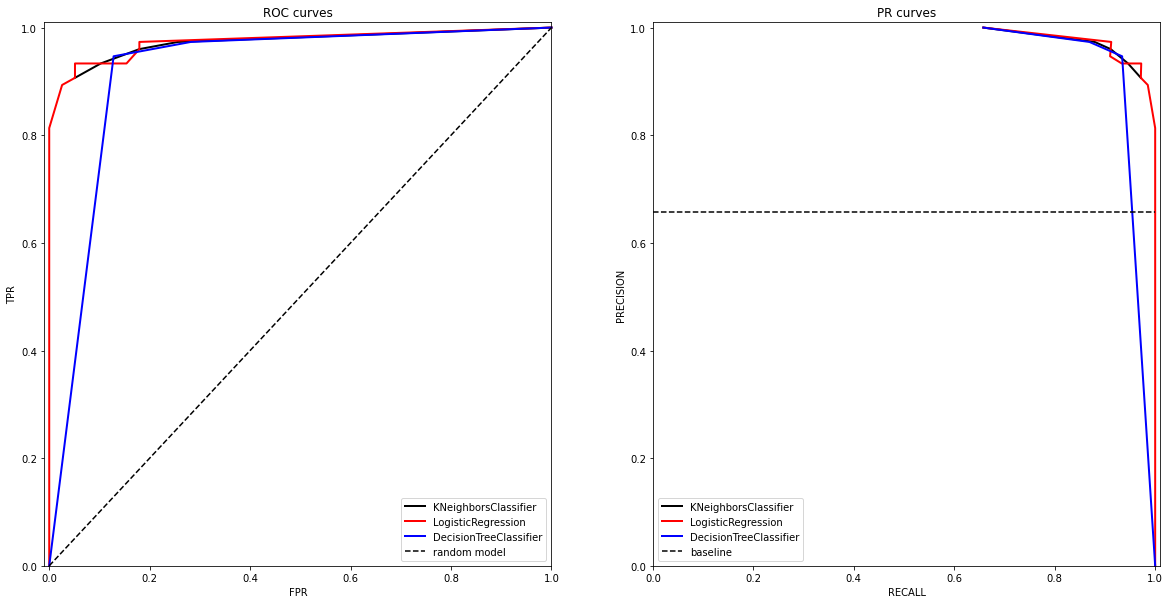

In [5]:
figure, axis = plt.subplots(1, 2, figsize=(20, 10)) 

colori = ['black','r','blue','green']

for i,algoritmo in enumerate(algoritmi.values()):
    clf = algoritmo.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)[:, 1]
    tpr_vec, fpr_vec, score = get_ROC_curve(y_test,preds)
    recall, precision, score = get_PR_curve(y_test,preds)
    name_alg = str(algoritmo).split("(")[0]
    axis[0].plot(fpr_vec, tpr_vec, linestyle='-', marker='', color=colori[i], lw = 2, label=name_alg, clip_on=False)
    axis[1].plot(recall, precision, linestyle='-', marker='', color=colori[i], lw = 2, label=name_alg, clip_on=False)


#Configurazione e stampa del grafico
axis[0].plot([0, 1], [0, 1], color='black', linestyle='--', label = "random model")
axis[0].set_xlim([-0.01, 1.0])
axis[0].set_ylim([0.0, 1.01])
axis[0].set_xlabel('FPR')
axis[0].set_ylabel('TPR')
axis[0].set_title('ROC curves')
axis[0].legend(loc="lower right")

baseline = len(y_test[y_test==1]) / len(y_test)
axis[1].plot([0, 1], [baseline,baseline], color='black', linestyle='--', label = "baseline")
axis[1].set_xlim([0.0, 1.01])
axis[1].set_ylim([0.0, 1.01])
axis[1].set_xlabel('RECALL')
axis[1].set_ylabel('PRECISION')
axis[1].set_title('PR curves')
axis[1].legend(loc="lower left")

plt.savefig('ROC-PR_Curves.png')    
plt.show()

### DEFINE THE FUNCTIONS TO GET THE SCORES

In [6]:
def get_performance(clf, X, Y, metric):
    score = None
    if metric == 'accuracy':
        score = round(clf.score(X, Y) * 100, 2)
    if metric == 'auc_roc':
        preds = clf.predict_proba(X)[:, 1]
        tpr, fpr, score = get_ROC_curve(Y,preds)        
        score = round(score * 100, 2)
    if metric == 'auc_pr':
        preds = clf.predict_proba(X)[:, 1]
        precision, tpr, score = get_PR_curve(Y,preds)        
        score = round(score * 100, 2)
    return score

def get_performance_from_algorithm(algorithm, X_train, y_train, X_test, y_test, metric):
    clf = algorithm.fit(X_train, y_train)
    return get_performance(clf, X_test, y_test, metric)

### BUILDING AND PRINTING THE TABLE

In [7]:
performance_tables = []
for metric in metrics:    
    diz = {}
    for name, algoritmo in algoritmi.items():
        diz[name] = get_performance_from_algorithm(algoritmo, X_train, y_train, X_test, y_test, metric)
    
    data_as_diz = {
        'model': diz.keys(),
        metric: diz.values()
    } 
    model_perf_table = pd.DataFrame.from_dict(data_as_diz).set_index('model')
    performance_tables.append(model_perf_table)
    
comparison_table = pd.concat(performance_tables, axis = 1)
comparison_table

/Users/gatsu82/miniforge3/envs/spark_py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gatsu82/miniforge3/envs/spark_py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

,accuracy,auc_roc,auc_pr
model,,,
knn,92.11,92.80,8.28
lin_reg,92.98,97.45,98.92
dec_tree,92.11,91.68,95.99
